In [28]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = "data/prizes-1000.json"

with open(file_path, 'r') as file:
    data = json.load(file)

In [6]:
print(json.dumps(data['nobelPrizes'][0], indent=2))

{
  "awardYear": "1901",
  "category": {
    "en": "Chemistry",
    "no": "Kjemi",
    "se": "Kemi"
  },
  "categoryFullName": {
    "en": "The Nobel Prize in Chemistry",
    "no": "Nobelprisen i kjemi",
    "se": "Nobelpriset i kemi"
  },
  "dateAwarded": "1901-11-12",
  "prizeAmount": 150782,
  "prizeAmountAdjusted": 10531894,
  "links": [
    {
      "rel": "nobelPrize",
      "href": "https://api.nobelprize.org/2/nobelPrize/che/1901",
      "action": "GET",
      "types": "application/json"
    }
  ],
  "laureates": [
    {
      "id": "160",
      "knownName": {
        "en": "Jacobus H. van 't Hoff"
      },
      "fullName": {
        "en": "Jacobus Henricus van 't Hoff"
      },
      "portion": "1",
      "sortOrder": "1",
      "motivation": {
        "en": "in recognition of the extraordinary services he has rendered by the discovery of the laws of chemical dynamics and osmotic pressure in solutions",
        "se": "s\u00e5som ett erk\u00e4nnande av den utomordentliga f\u00f

In [8]:
prize_data = []

In [9]:
# Need to exclude Peace and Literature prizes
for prize in data['nobelPrizes']:
    category = prize.get('category', {}).get('en')
    if category in ['Literature', 'Peace', 'Economic Sciences']:  # Exclude 'Literature' and 'Peace'
        continue
    laureates = prize.get('laureates')
    if laureates is None:
        continue

    prize_data.append({
        'category': category,
        'year': prize.get('awardYear'),
        'laureates': len(prize.get('laureates'))
    })

In [10]:
len(prize_data)

346

This matches the number of sciece Prizes listed on the Nobel Prize Website.

- Physics: 	117
- Chemistry: 115
- Medicine: 114

Total = 346

In [11]:
prize_df = pd.DataFrame(prize_data)

In [12]:
prize_df.head()

,category,year,laureates
0,Chemistry,1901,1
1,Physics,1901,1
2,Physiology or Medicine,1901,1
3,Chemistry,1902,1
4,Physics,1902,2


In [22]:
# Rearrange prize_df to have categories as columns
prize_df_by_year = prize_df.pivot(index='year', columns='category', values='laureates')

In [23]:
prize_df_by_year.head()

category,Chemistry,Physics,Physiology or Medicine
year,,,
1901,1.0,1.0,1.0
1902,1.0,2.0,1.0
1903,1.0,3.0,1.0
1904,1.0,1.0,1.0
1905,1.0,1.0,1.0


---

## Proportion of solo winners per year

In [24]:
# For each year, count the instances 1.0 appearing in each category
# Add this as a new column named solo_winner
prize_df_by_year['solo_winner'] = prize_df_by_year.apply(lambda row: sum(row == 1), axis=1)

In [25]:
prize_df_by_year.head()

category,Chemistry,Physics,Physiology or Medicine,solo_winner
year,,,,
1901,1.0,1.0,1.0,3
1902,1.0,2.0,1.0,2
1903,1.0,3.0,1.0,2
1904,1.0,1.0,1.0,3
1905,1.0,1.0,1.0,3


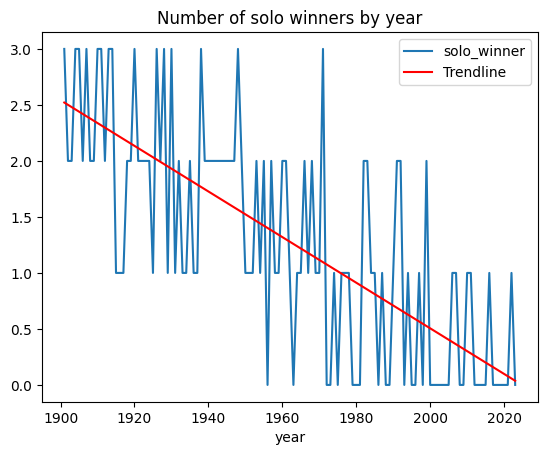

In [29]:
# Extract the data for the x and y axes
x = prize_df_by_year.index
y = prize_df_by_year['solo_winner']

# Perform a linear regression to get the trendline
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# Plot the original data
ax = prize_df_by_year.plot(kind='line', y='solo_winner', title='Number of solo winners by year')

# Plot the trendline
plt.plot(x, trendline(x), label='Trendline', color='red')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [30]:
prize_df_by_year.to_csv('output/Shared Prizes/solo-winners-per-year.csv')

---

## Shared prizes per decade

In [13]:
# Count the instances of each category
prize_df['category'].value_counts()

category
Physics                   117
Chemistry                 115
Physiology or Medicine    114
Name: count, dtype: int64

In [14]:
# Split the data by category and count the instances of 1, 2 and 3 in the laureates column
grouped_data = prize_df.groupby('category')['laureates'].value_counts().unstack().fillna(0)

In [15]:
grouped_data

laureates,1,2,3
category,,,
Chemistry,63,25,27
Physics,47,32,38
Physiology or Medicine,40,35,39


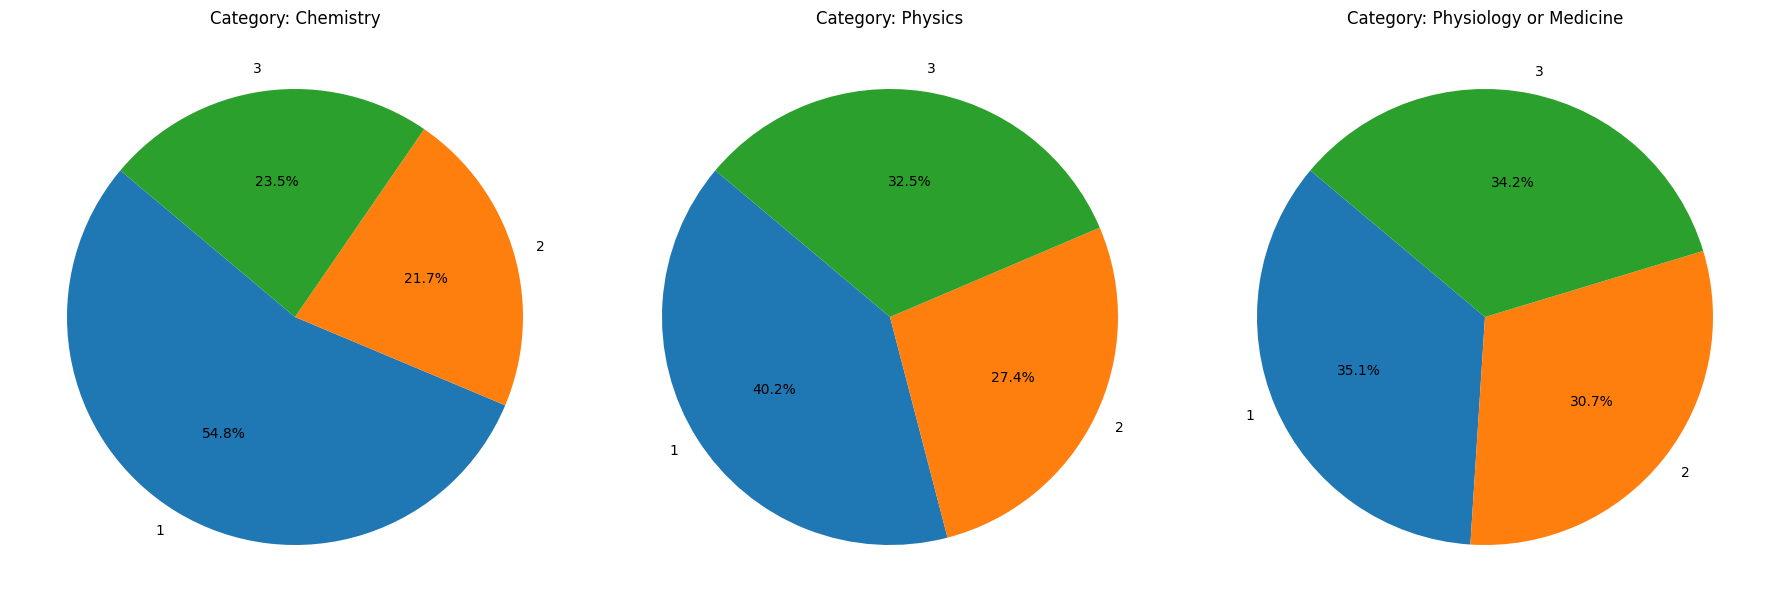

In [16]:
# Plot pie charts for each category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (category, counts) in zip(axes, grouped_data.iterrows()):
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Category: {category}')

plt.tight_layout()
plt.show()

In [17]:
# For pize_df convert the year column to integers
prize_df['year'] = prize_df['year'].astype(int)

In [18]:
# For each category, in prize_df count the instances of 2 or 3 laureates per decade
prize_df['decade'] = prize_df['year'] // 10 * 10
grouped_data_by_decade = prize_df[prize_df['laureates'] >= 2].groupby('category')['decade'].value_counts().unstack().fillna(0)

In [19]:
grouped_data_by_decade

decade,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
category,,,,,,,,,,,,,
Chemistry,0.0,1.0,1.0,4.0,1.0,4.0,4.0,4.0,7.0,5.0,8.0,9.0,4.0
Physics,3.0,1.0,2.0,3.0,0.0,8.0,4.0,9.0,8.0,8.0,10.0,10.0,4.0
Physiology or Medicine,2.0,0.0,3.0,3.0,5.0,6.0,9.0,9.0,8.0,8.0,10.0,8.0,3.0


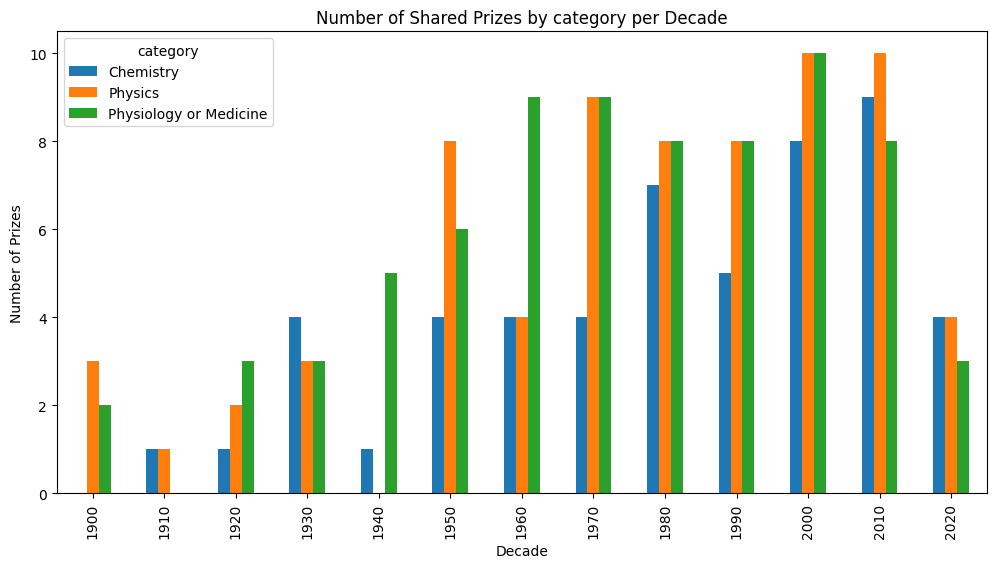

In [20]:
grouped_data_by_decade.T.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Shared Prizes by category per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Prizes')
plt.show()

In [21]:
grouped_data_by_decade.to_csv('output/Shared Prizes/grouped_data_by_decade.csv')